In [4]:
import random
import progressbar
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from livelossplot import PlotLosses
from sklearn.model_selection import StratifiedShuffleSplit
from pycm import *

In [11]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

In [5]:
c1_output = 6
c3_output = 16


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.c1 = nn.Conv2d(in_channels = 3, out_channels = c1_output,
                            kernel_size=5, stride=1, padding=2) 


        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.c3 = nn.Conv2d(in_channels = c1_output, out_channels = c3_output,
                            kernel_size=5, stride=1, padding = 0)   
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(c3_output*6*6, 120)    
        self.f6 = nn.Linear(120, 84)   
        self.output = nn.Linear(84, 10)  
        self.act = nn.ReLU()           
    
    def forward(self, x):
        x = self.act(self.c1(x))    
        x = self.act(self.s2(x))   
        x = self.act(self.c3(x))   
        x = self.act(self.s4(x))    
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))     
        x = self.act(self.c5(x))       
        x = self.act(self.f6(x))    
        return self.output(x)     

In [6]:
CIFAR_train=datasets.CIFAR10(root='./data',train=True,download=True)  
CIFAR_test=datasets.CIFAR10(root='./data',train=False,download=True) 

## To do Normalization, first divide RGB by 255 each

DEBUG = False

CIFAR_train_red = np.asarray(CIFAR_train.data[:,:,:,0], dtype=np.float32)/255
CIFAR_train_green = np.asarray(CIFAR_train.data[:,:,:,1], dtype = np.float32)/255
CIFAR_train_blue = np.asarray(CIFAR_train.data[:,:,:,2], dtype = np.float32)/255

CIFAR_red = (np.vstack([CIFAR_train_red]))
CIFAR_green = (np.vstack([CIFAR_train_green]))
CIFAR_blue = (np.vstack([CIFAR_train_blue]))

CIFAR_mean = (np.mean(CIFAR_red), np.mean(CIFAR_green), np.mean(CIFAR_blue))
CIFAR_std = (np.std(CIFAR_red), np.std(CIFAR_green), np.std(CIFAR_blue))

def train_normalization(pixel):

    pixel[0] = ((pixel[0]/255) - CIFAR_mean[0])/CIFAR_std[0]
    pixel[1] = ((pixel[1]/255) - CIFAR_mean[1])/CIFAR_std[1]
    pixel[2] = ((pixel[2]/255) - CIFAR_mean[2])/CIFAR_std[2]
    
    return pixel



Files already downloaded and verified
Files already downloaded and verified


In [7]:
# This cell takes a really long time to run, so try to run it only once

shuffler = StratifiedShuffleSplit(n_splits=1,
                                  test_size=0.1,
                                  random_state=42).split(CIFAR_train.data,
                                                         CIFAR_train.targets)

indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]


CIFAR_train.data = np.asarray(CIFAR_train.data, dtype=np.float32)


X_train = CIFAR_train.data[indices[0],:,:,:]
X_val = CIFAR_train.data[indices[1],:,:,:]

for i in range(len(X_train)):
    for j in range(32):
        for k in range(32):
            X_train[i,j,k] = train_normalization(X_train[i,j,k])
            
for i in range(len(X_val)):
    for j in range(32):
        for k in range(32):
            X_val[i,j,k] = train_normalization(X_val[i,j,k])

y_train = np.zeros(indices[0].shape, dtype=int)
y_val = np.zeros(indices[1].shape, dtype =int)


for index in range(len(y_train)):
    y_train[index] = CIFAR_train.targets[indices[0][index]]

for index in range(len(y_val)):
    y_val[index] = CIFAR_train.targets[indices[1][index]]          
    
X_train_tensor = torch.from_numpy(X_train)
X_val_tensor = torch.from_numpy(X_val)
y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)

CIFAR_train_dataset = TensorDataset(X_train_tensor, y_train_tensor.long()) 
CIFAR_val_dataset = TensorDataset(X_val_tensor, y_val_tensor.long()) 

In [14]:
seed = 42
lr = 1e-2
momentum = 0.8
batch_size = 640
n_epochs = 30
device = 'cpu'


test_batch_size = 1000
set_seed(seed)
model=LeNet5().to(device)  
criteron=nn.CrossEntropyLoss()  
optimizer=torch.optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum)

CIFAR_train_loader = DataLoader(CIFAR_train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0)

CIFAR_val_loader = DataLoader(CIFAR_val_dataset,
                              batch_size=test_batch_size,
                              shuffle=False,
                              num_workers=0)

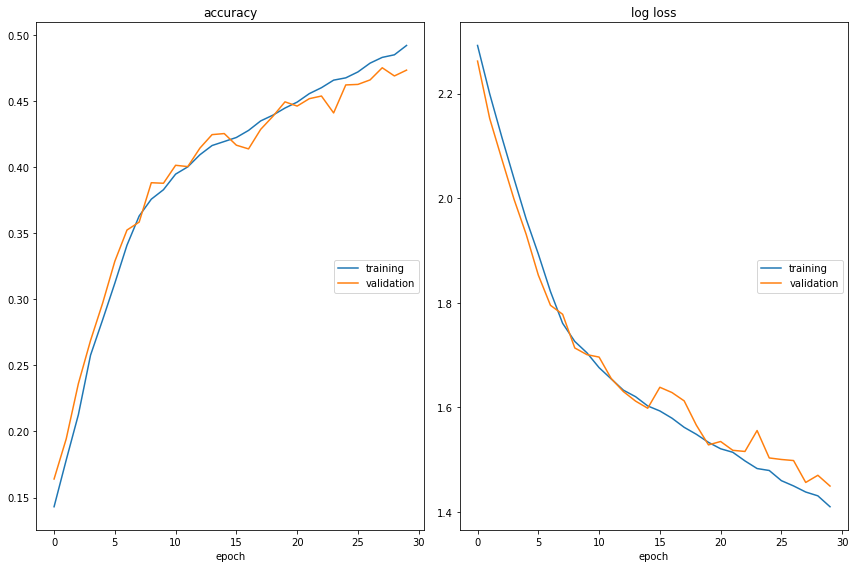

accuracy
	training         	 (min:    0.143, max:    0.492, cur:    0.492)
	validation       	 (min:    0.164, max:    0.475, cur:    0.473)
log loss
	training         	 (min:    1.410, max:    2.292, cur:    1.410)
	validation       	 (min:    1.449, max:    2.262, cur:    1.449)
Seed is  42
Learning Rate is  0.01
Momentum is  0.8
Batch size is  640
Number of Epochs is  30


In [15]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 3, 32, 32))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

def train_model():
    
    set_seed(seed)
    model = LeNet5().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
      
    ## Repated it here just in case I accidentally delete the loader somehow
    CIFAR_train_loader = DataLoader(CIFAR_train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=0)

    CIFAR_val_loader = DataLoader(CIFAR_val_dataset,
                                  batch_size=test_batch_size,
                                  shuffle=False,
                                  num_workers=0)
  
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, CIFAR_train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, CIFAR_val_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

model = train_model()

print("Seed is ", seed)
print("Learning Rate is ", lr)
print("Momentum is ", momentum)
print("Batch size is ", batch_size)
print("Number of Epochs is ", n_epochs)

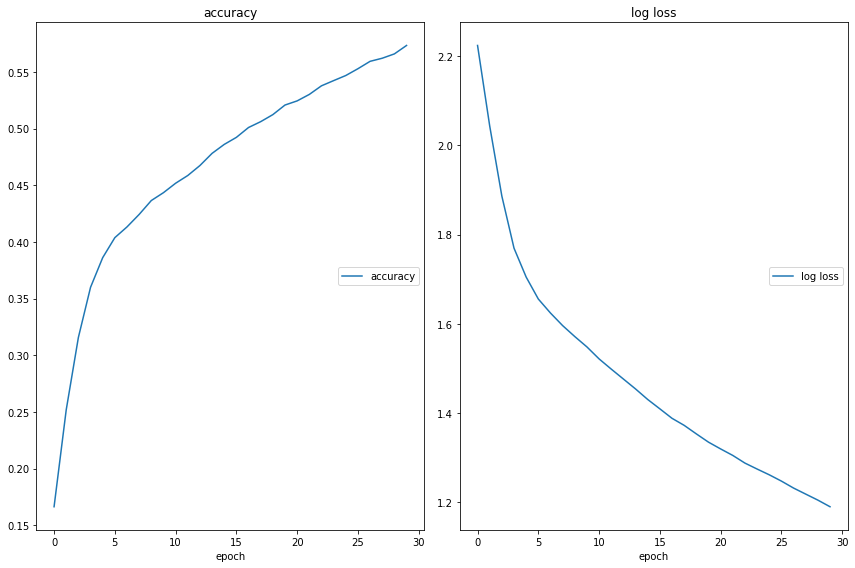

accuracy
	accuracy         	 (min:    0.166, max:    0.573, cur:    0.573)
log loss
	log loss         	 (min:    1.190, max:    2.224, cur:    1.190)
Avg. Test Loss: 1.354  Avg. Test Accuracy: 0.516



In [16]:
## Reload the CIFAR dataset

CIFAR_train=datasets.CIFAR10(root='./data',train=True,download=True)  
CIFAR_test=datasets.CIFAR10(root='./data',train=False,download=True) 

CIFAR_train.data = np.asarray(CIFAR_train.data, dtype=np.float32)
CIFAR_test.data = np.asarray(CIFAR_test.data, dtype=np.float32)

## To do Normalization, first divide RGB by 255 each

DEBUG = False

CIFAR_test_red = np.asarray(CIFAR_test.data[:,:,:,0], dtype = np.float32)/255
CIFAR_test_green = np.asarray(CIFAR_test.data[:,:,:,1], dtype = np.float32)/255
CIFAR_test_blue = np.asarray(CIFAR_test.data[:,:,:,2], dtype = np.float32)/255

CIFAR_test_red_stack = (np.vstack([CIFAR_test_red, CIFAR_test_red]))
CIFAR_test_green_stack = (np.vstack([CIFAR_test_green, CIFAR_test_green]))
CIFAR_test_blue_stack = (np.vstack([CIFAR_test_blue, CIFAR_test_blue]))

# Then find mean and std

if DEBUG == True:
    print(np.mean(CIFAR_test_red_stack))
    print(np.mean(CIFAR_test_green_stack))
    print(np.mean(CIFAR_test_blue_stack))

    print(np.std(CIFAR_test_red_stack, dtype=np.float32))
    print(np.std(CIFAR_test_green_stack, dtype=np.float32))
    print(np.std(CIFAR_test_blue_stack, dtype=np.float32))

CIFAR_test_mean = (np.mean(CIFAR_test_red_stack),
                   np.mean(CIFAR_test_green_stack),
                   np.mean(CIFAR_test_blue_stack))
CIFAR_test_std = (np.std(CIFAR_test_red_stack),
                  np.std(CIFAR_test_green_stack),
                  np.std(CIFAR_test_blue_stack))

print(CIFAR_test_mean)
print(CIFAR_test_std)

def test_normalization(pixel):

    pixel[0] = ((pixel[0]/255) - CIFAR_test_mean[0])/CIFAR_test_std[0]
    pixel[1] = ((pixel[1]/255) - CIFAR_test_mean[1])/CIFAR_test_std[1]
    pixel[2] = ((pixel[2]/255) - CIFAR_test_mean[2])/CIFAR_test_std[2]
    
    return pixel

## Preparing the tensordataset

X_train_and_val = CIFAR_train.data[:,:,:,:]
X_test = CIFAR_test.data[:,:,:,:]

for i in range(len(X_train_and_val)):
    for j in range(32):
        for k in range(32):
            X_train_and_val[i,j,k] = train_normalization(X_train_and_val[i,j,k])
            
for i in range(len(X_test)):
    for j in range(32):
        for k in range(32):
            X_test[i,j,k] = test_normalization(X_test[i,j,k])

y_train_and_val = np.zeros(X_train_and_val.shape[0], dtype=int)
y_test = (CIFAR_test.targets)

for index in range(len(y_train_and_val)):
    y_train_and_val[index] = CIFAR_train.targets[index]
    
y_test = np.asarray(y_test, dtype = int)

X_train_and_val_tensor = torch.from_numpy(X_train_and_val)
X_test_tensor = torch.from_numpy(X_test)
y_train_and_val_tensor = torch.from_numpy(y_train_and_val)
y_test_tensor = torch.from_numpy(y_test)

CIFAR_train_and_val_dataset = TensorDataset(X_train_and_val_tensor, y_train_and_val_tensor.long()) 
CIFAR_test_dataset = TensorDataset(X_test_tensor, y_test_tensor.long()) 

seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 128
n_epochs = 30

test_batch_size = 1000

train_loader = DataLoader(CIFAR_train_and_val_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
    
test_loader = DataLoader(CIFAR_test_dataset,
                         batch_size=test_batch_size,
                         shuffle=False,
                         num_workers=0)

test_loss, test_accuracy = validate(model, criterion, test_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(),
      " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")
